In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

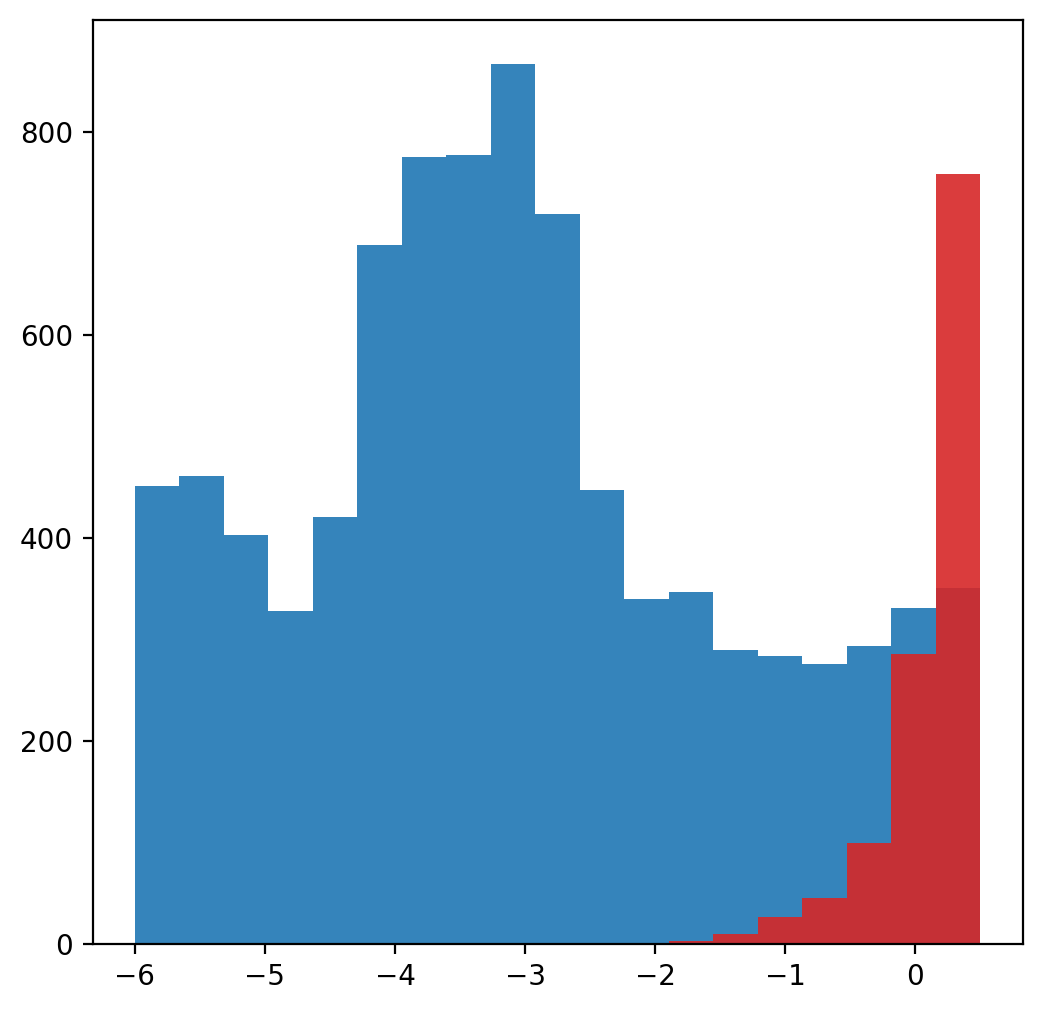

In [2]:
epoch = 499
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")

bins = np.linspace(-6, 0.5, 20)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(
    np.log10(model_probabilities_saved_sims[:, 0]),
    bins=bins,
    alpha=0.9,
    color="tab:blue",
)
ax.hist(
    np.log10(model_probabilities_saved_real[:, 0]),
    bins=bins,
    alpha=0.9,
    color="tab:red",
)
plt.yscale('linear')
plt.show()

In [5]:
import numpy as np
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

def estimate_distribution(samples, bandwidth=0.01):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(samples[:, np.newaxis])
    return kde

def compute_kl_divergence(p, q, X):
    log_p = p.score_samples(X[:, np.newaxis])
    log_q = q.score_samples(X[:, np.newaxis])
    return np.sum(np.exp(log_p) * (log_p - log_q)) / X.shape[0]

def compute_jsd(p_samples, q_samples, bandwidth=0.01):
    p = estimate_distribution(p_samples, bandwidth)
    q = estimate_distribution(q_samples, bandwidth)
    print("Here")
    X = np.linspace(min(np.min(p_samples), np.min(q_samples)),
                    max(np.max(p_samples), np.max(q_samples)), 1000)
    m = 0.5 * (p.score_samples(X[:, np.newaxis]) + q.score_samples(X[:, np.newaxis]))
    m_kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    m_kde.fit(X[:, np.newaxis], sample_weight=np.exp(m))
    jsd = 0.5 * (compute_kl_divergence(p, m_kde, X) + compute_kl_divergence(q, m_kde, X))
    return jsd

In [51]:
# Assuming p_samples and q_samples are your 1D arrays of samples
epoch = 499
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
jsd_value = compute_jsd(np.log10(model_probabilities_saved_sims[:, 0]), np.log10(model_probabilities_saved_real[:, 0]))
print(f'JSD: {jsd_value}')

Here


/home/alveyjbg/mambaforge/envs/swyft-dev/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/alveyjbg/mambaforge/envs/swyft-dev/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


JSD: 560.6376748632417


In [49]:
# Assuming p_samples and q_samples are your 1D arrays of samples
epoch = 19999
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
jsd_value = compute_jsd(np.log10(model_probabilities_saved_sims[:, 0]), np.log10(model_probabilities_saved_real[:, 0]))
print(f'JSD: {jsd_value}')

JSD: 0.02857503396010679


/home/alveyjbg/mambaforge/envs/swyft-dev/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/alveyjbg/mambaforge/envs/swyft-dev/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


560.6376748632417


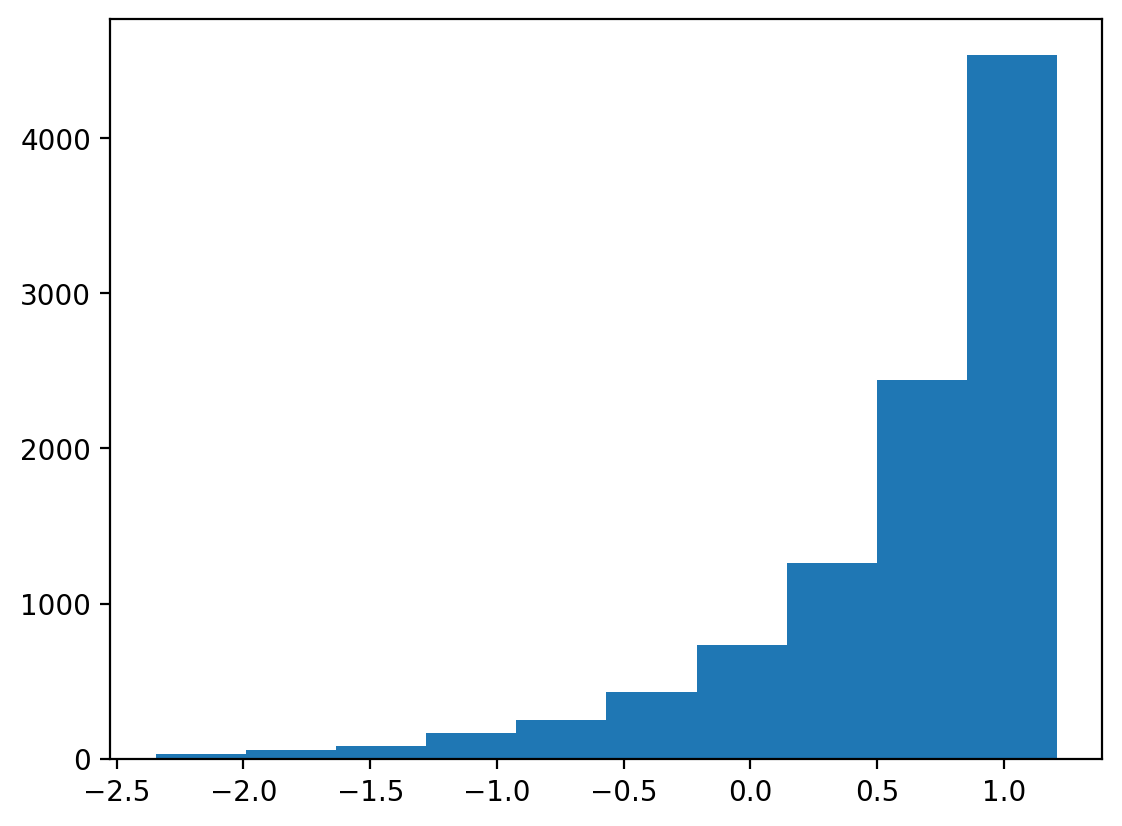

In [54]:
epoch = 499
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
kde_r = estimate_distribution(np.log10(model_probabilities_saved_real[:, 0]), bandwidth=0.01)
kde_s = estimate_distribution(np.log10(model_probabilities_saved_sims[:, 0]), bandwidth=0.01)

X = np.linspace(min(np.min(np.log10(model_probabilities_saved_real[:, 0])), np.min(np.log10(model_probabilities_saved_sims[:, 0]))),
                    max(np.max(np.log10(model_probabilities_saved_real[:, 0])), np.max(np.log10(model_probabilities_saved_sims[:, 0]))), 1000)
m = 0.5 * (kde_r.score_samples(X[:, np.newaxis]) + kde_s.score_samples(X[:, np.newaxis]))
m_kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
m_kde.fit(X[:, np.newaxis], sample_weight=np.exp(m))
plt.hist(m_kde.sample(10000))
jsd = 0.5 * (compute_kl_divergence(kde_r, m_kde, X) + compute_kl_divergence(kde_s, m_kde, X))
print(jsd)

0.4738811431833115


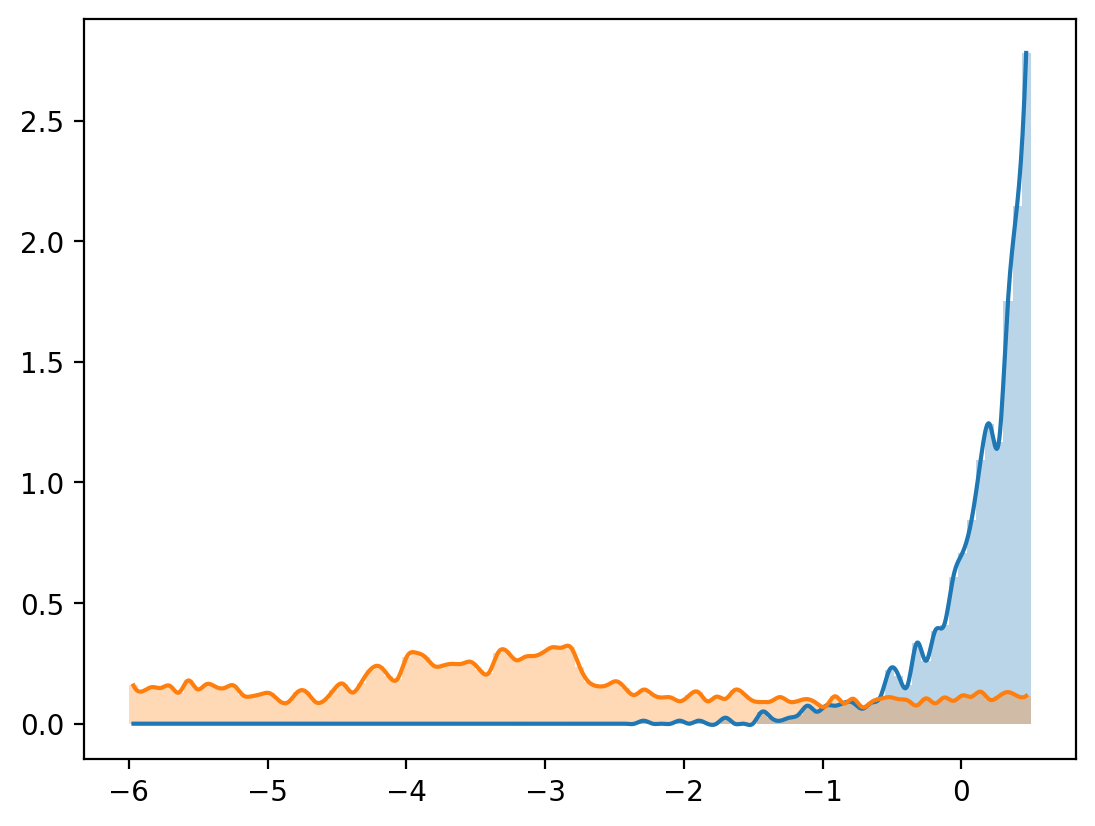

In [77]:
import pickle
import json
import sys
import swyft
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon

epoch = 499
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
result1 = np.log10(model_probabilities_saved_real[:, 0])
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
result2 = np.log10(model_probabilities_saved_sims[:, 0])

jsd_sum = 0.0
nbins = np.linspace(-6, 0.5, 100)

ax = plt.subplot(1, 1, 1)
h, bins = np.histogram(
    result1, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min1, max1 = bin_centres[0], bin_centres[-1]
fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


h, bins = np.histogram(
    result2, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min2, max2 = bin_centres[0], bin_centres[-1]
fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)
plt.plot(x_grid, fit1(x_grid))
plt.plot(x_grid, fit2(x_grid))

def fit_1(x):
    return max(1e-10, fit1(x))

def fit_2(x):
    return max(1e-10, fit2(x))

fit_1 = np.vectorize(fit_1)
fit_2 = np.vectorize(fit_2)

JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
jsd_sum += JSD
print(JSD)

0.09483790165699593


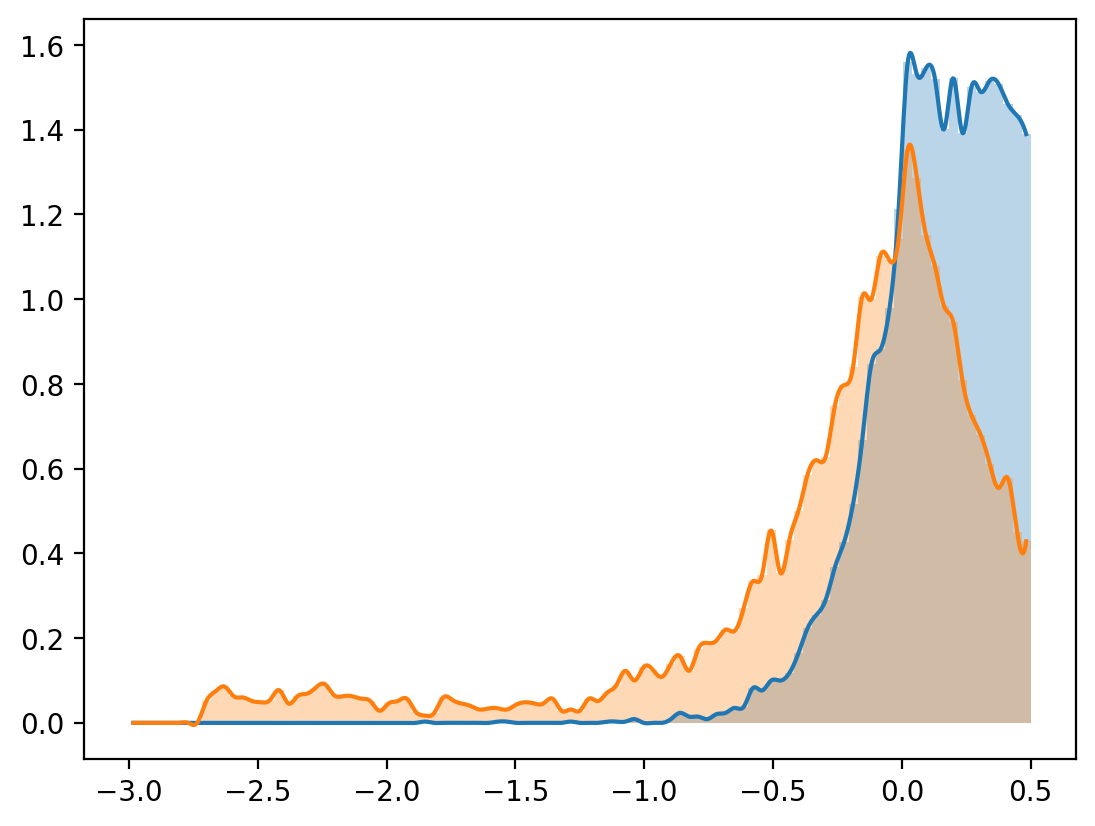

In [73]:
epoch = 3999
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
result1 = np.log10(model_probabilities_saved_real[:, 0])
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
result2 = np.log10(model_probabilities_saved_sims[:, 0])

jsd_sum = 0.0
nbins = np.linspace(-3, 0.5, 100)

ax = plt.subplot(1, 1, 1)
h, bins = np.histogram(
    result1, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min1, max1 = bin_centres[0], bin_centres[-1]
fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


h, bins = np.histogram(
    result2, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min2, max2 = bin_centres[0], bin_centres[-1]
fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)
plt.plot(x_grid, fit1(x_grid))
plt.plot(x_grid, fit2(x_grid))

def fit_1(x):
    return max(1e-10, fit1(x))

def fit_2(x):
    return max(1e-10, fit2(x))

fit_1 = np.vectorize(fit_1)
fit_2 = np.vectorize(fit_2)

JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
jsd_sum += JSD
print(JSD)

0.007078194629965658


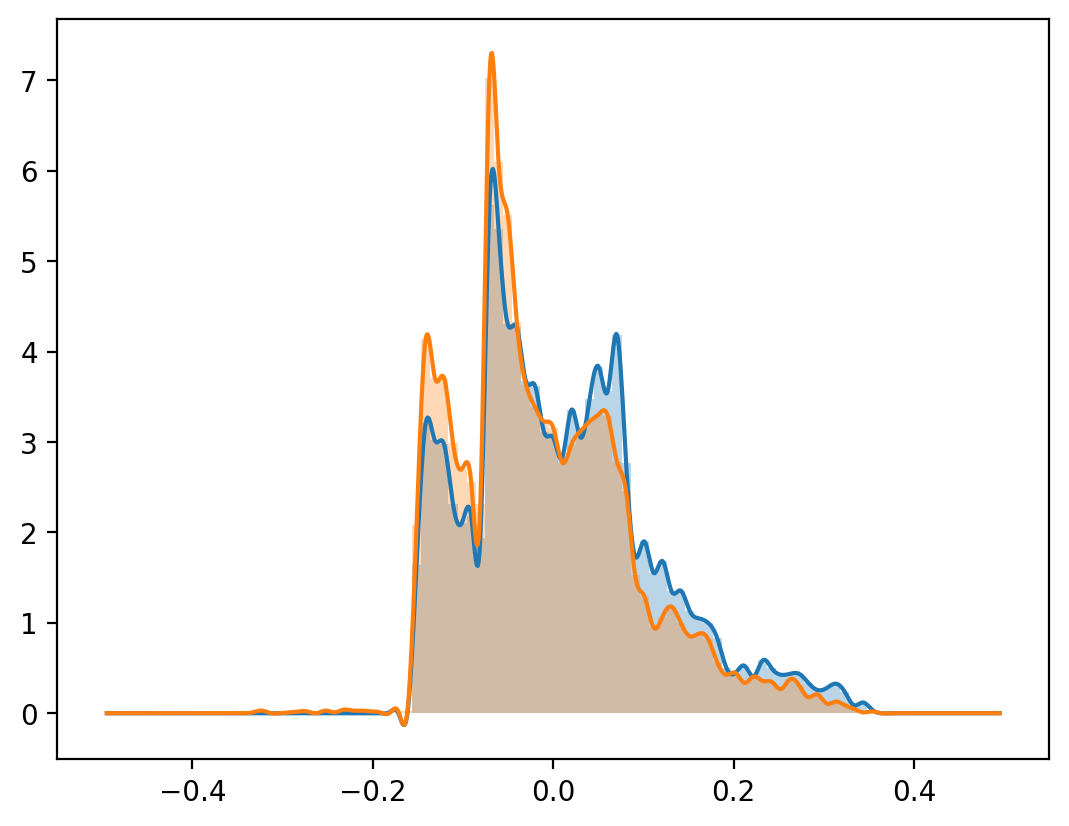

In [68]:
epoch = 19999
model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
result1 = np.log10(model_probabilities_saved_real[:, 0])
model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
result2 = np.log10(model_probabilities_saved_sims[:, 0])

jsd_sum = 0.0
nbins = np.linspace(-0.5, 0.5, 100)

ax = plt.subplot(1, 1, 1)
h, bins = np.histogram(
    result1, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min1, max1 = bin_centres[0], bin_centres[-1]
fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


h, bins = np.histogram(
    result2, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min2, max2 = bin_centres[0], bin_centres[-1]
fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)
plt.plot(x_grid, fit1(x_grid))
plt.plot(x_grid, fit2(x_grid))

def fit_1(x):
    return max(1e-10, fit1(x))

def fit_2(x):
    return max(1e-10, fit2(x))

fit_1 = np.vectorize(fit_1)
fit_2 = np.vectorize(fit_2)

JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
jsd_sum += JSD
print(JSD)

/home/alveyjbg/mambaforge/envs/swyft-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.4591776854688199


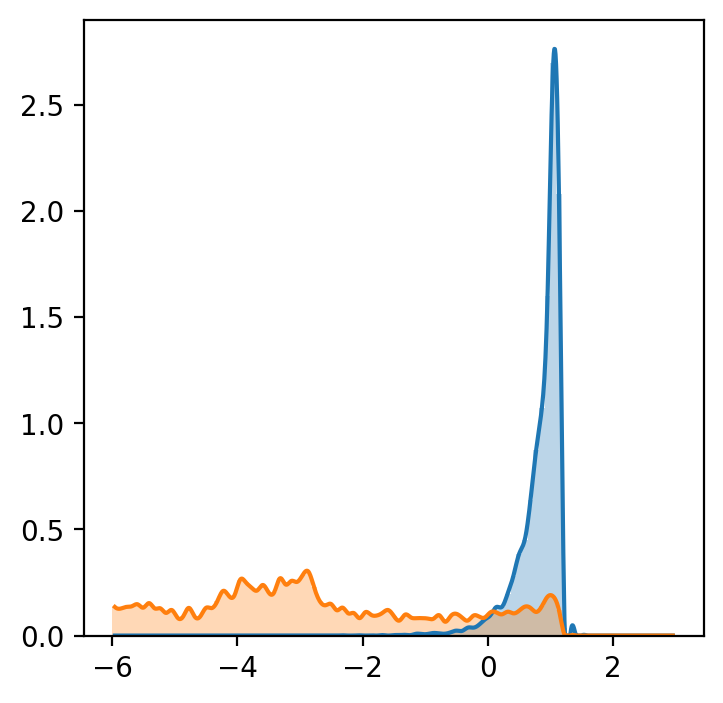

0.4566931922174119


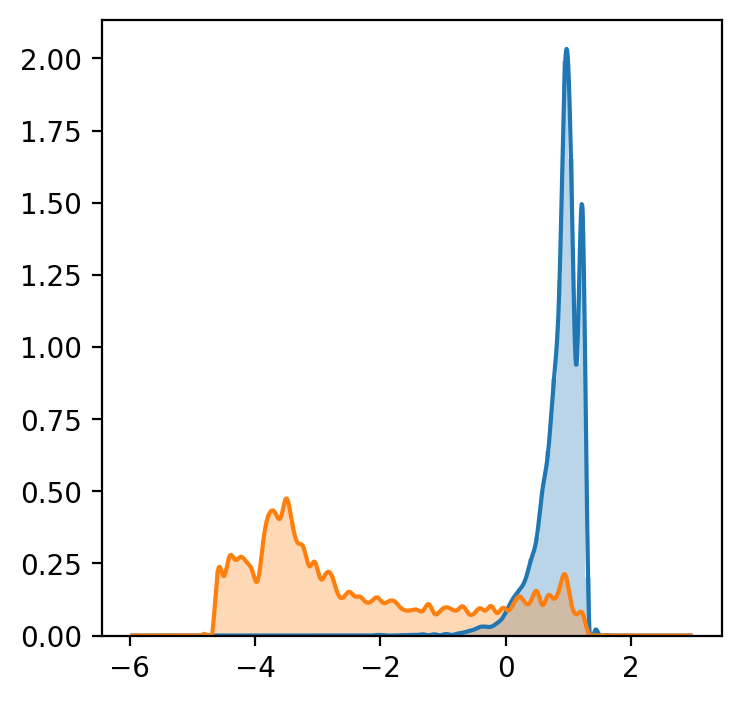

0.43168748677580204


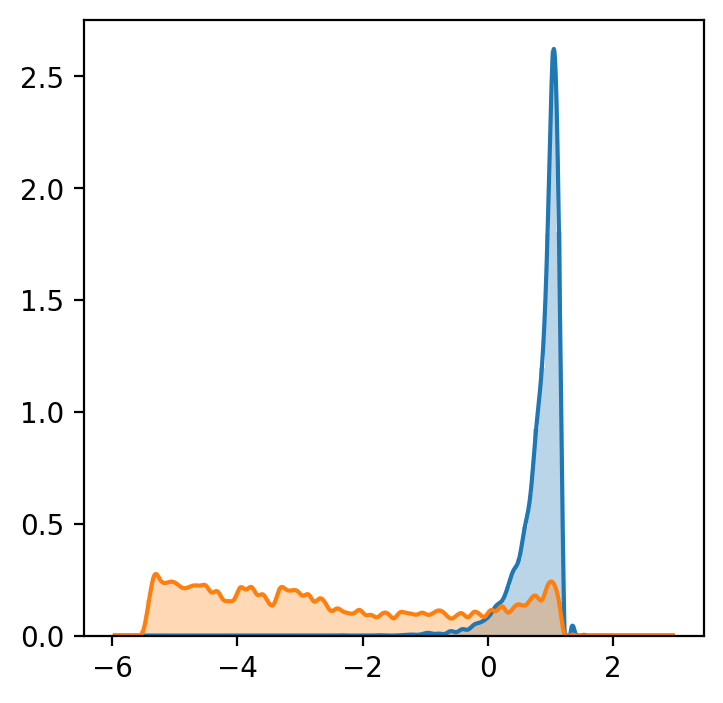

0.3901824296815689


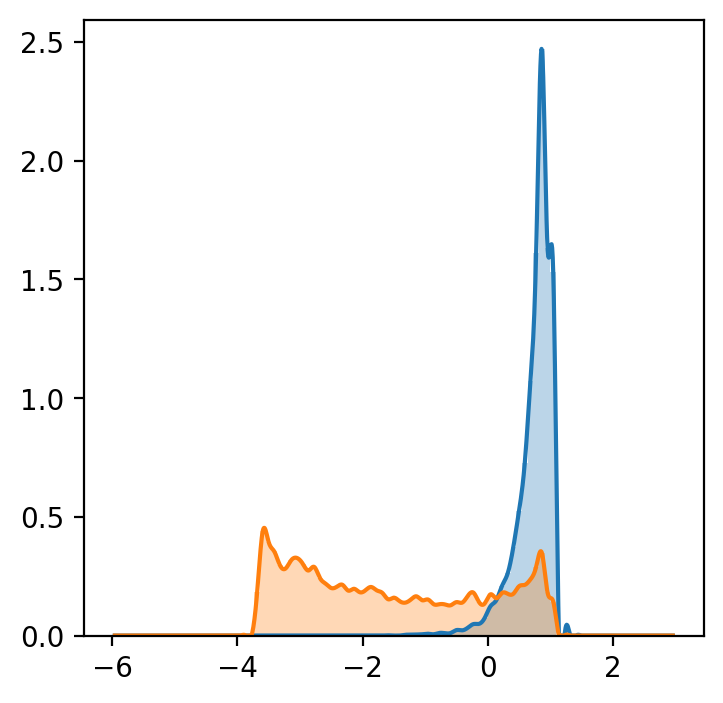

0.18322358408361503


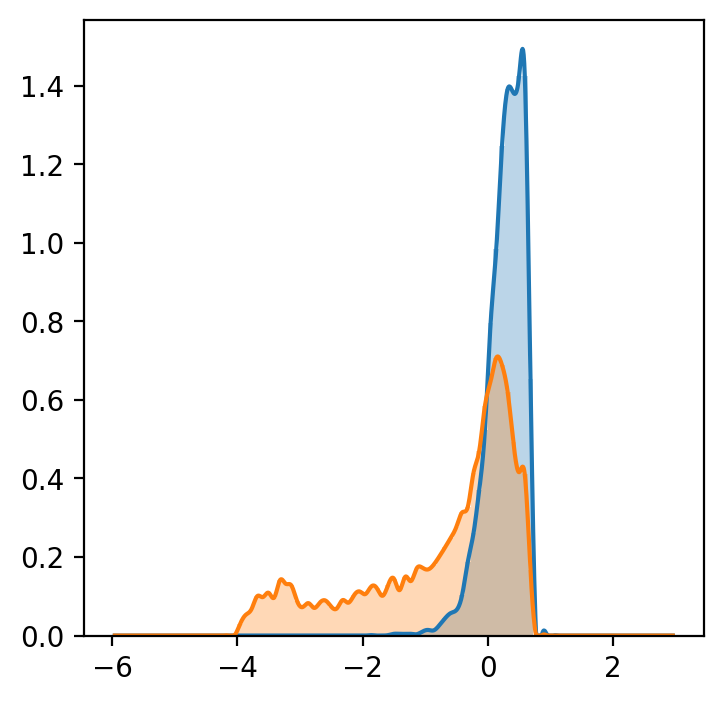

0.14447398364638778


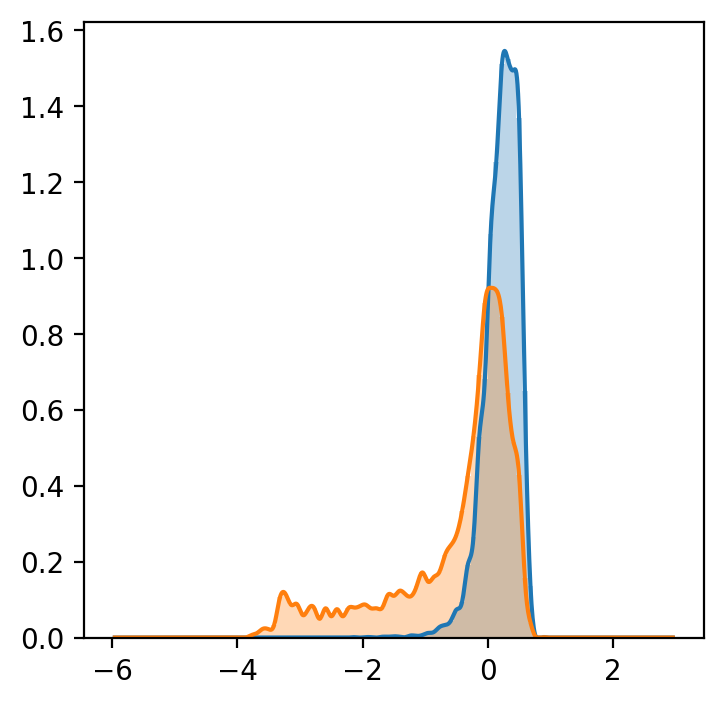

0.11467718381315059


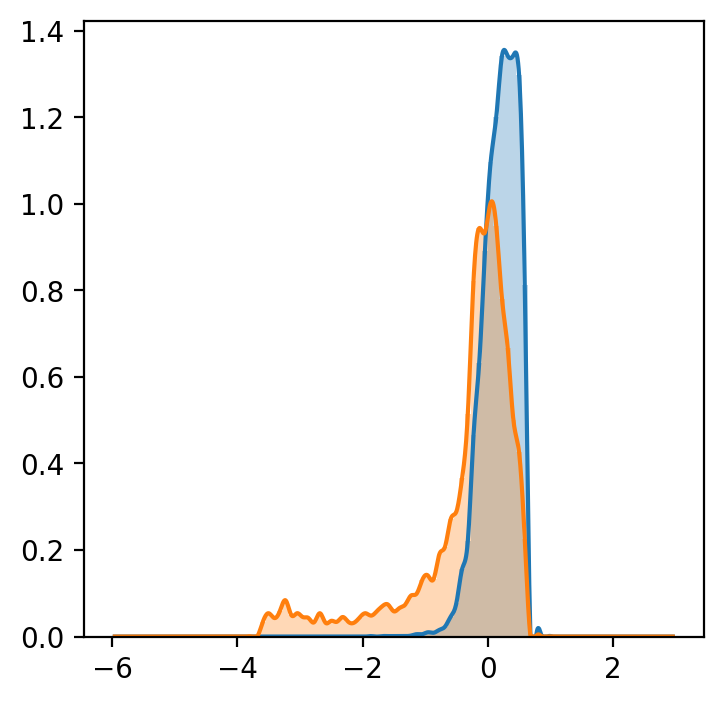

0.09618531865866706


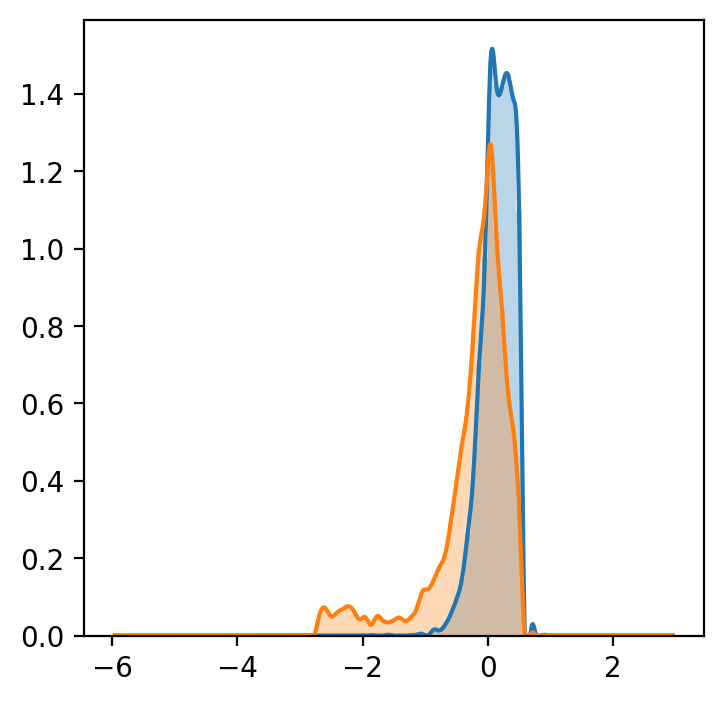

0.09453152462522947


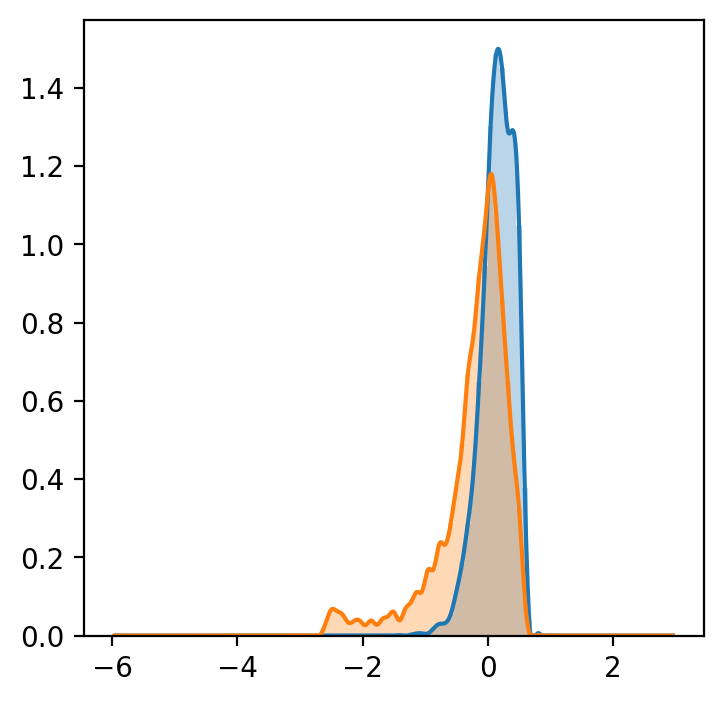

0.06597002241013784


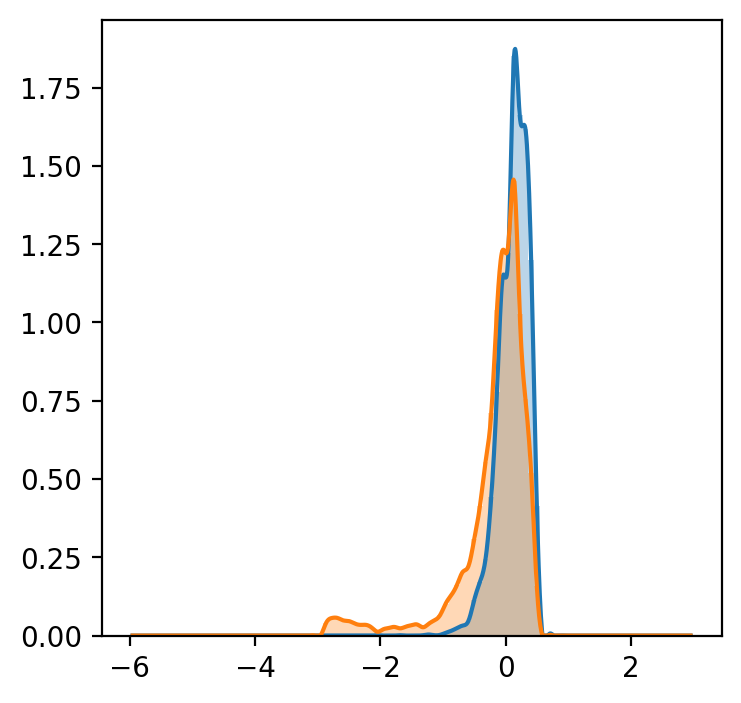

0.05892580773661032


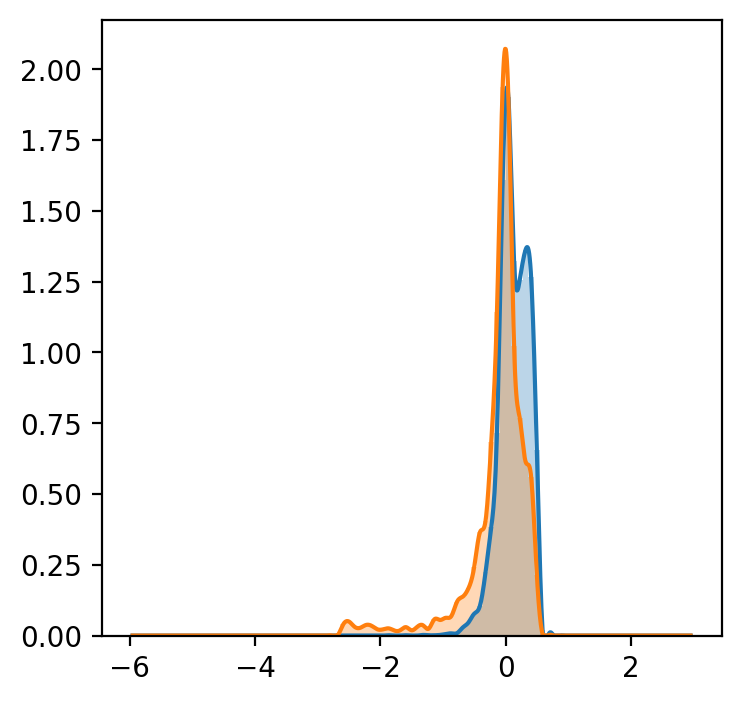

0.04265896248890565


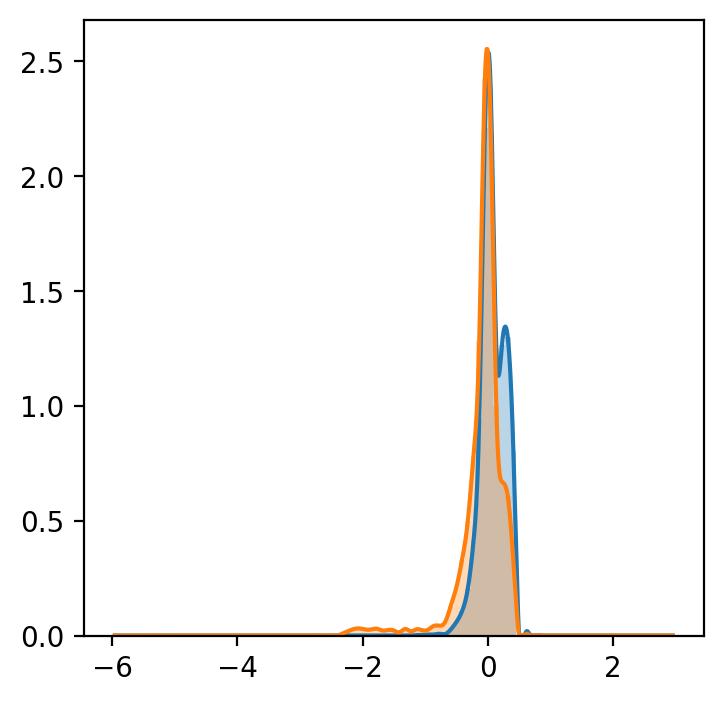

0.034193091473773383


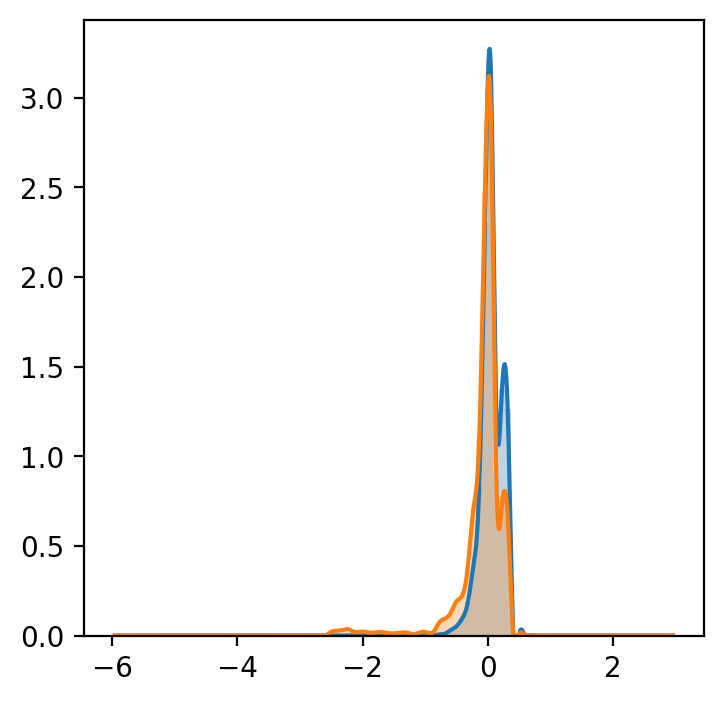

0.029425742274486907


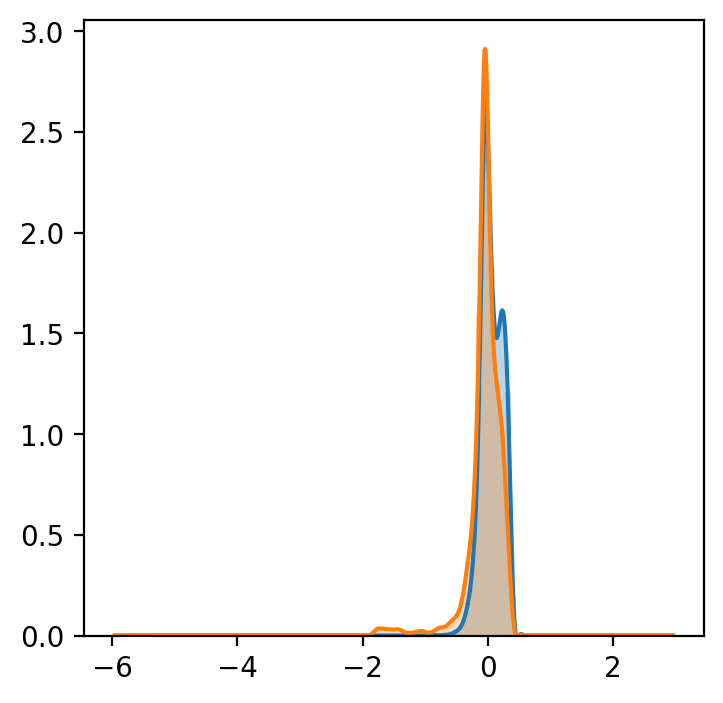

0.026427500243630095


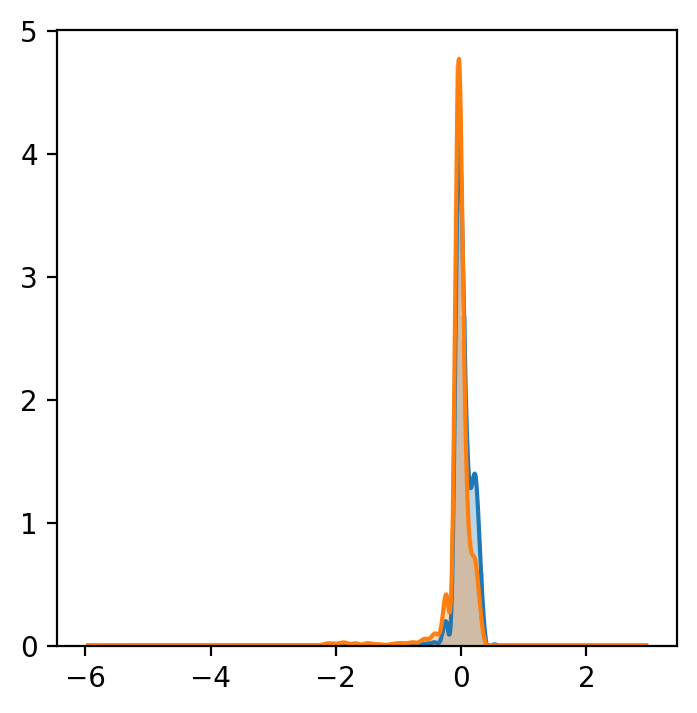

0.02016346946378569


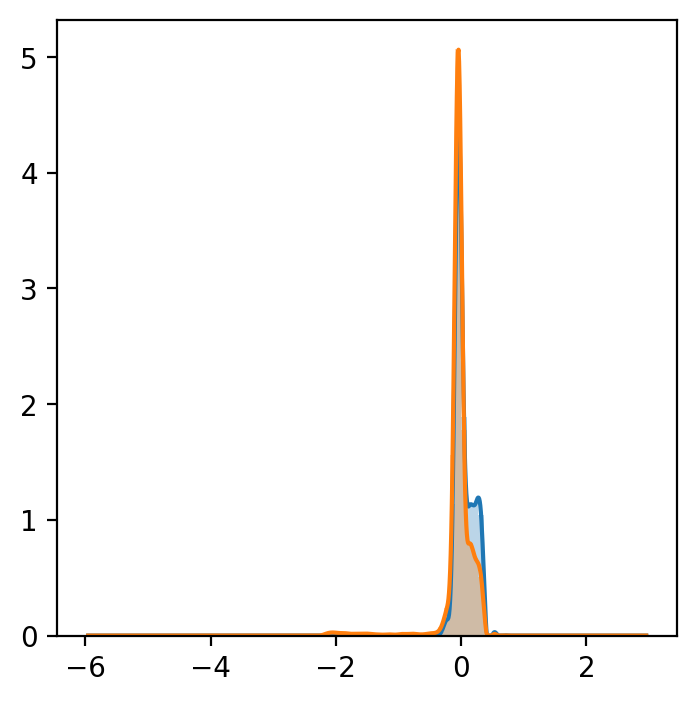

0.02355633302896228


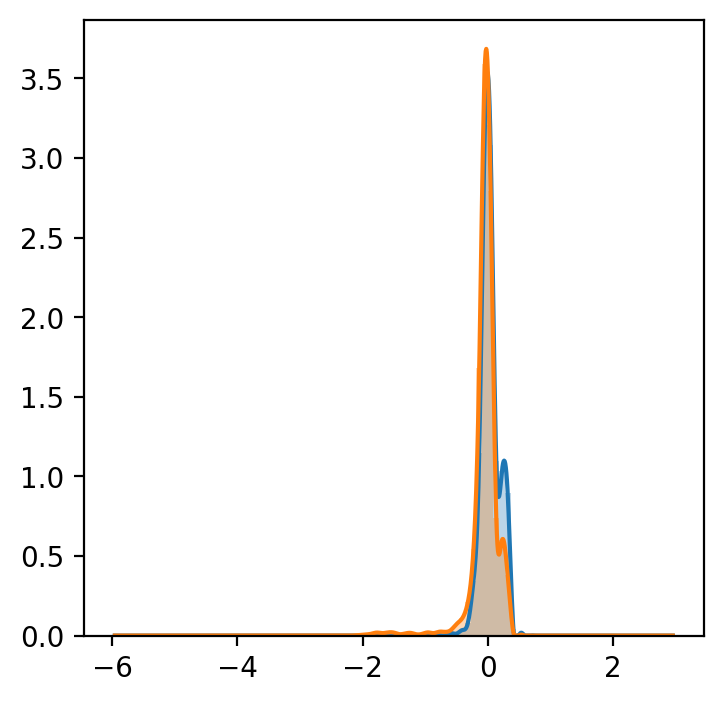

0.012653656384328396


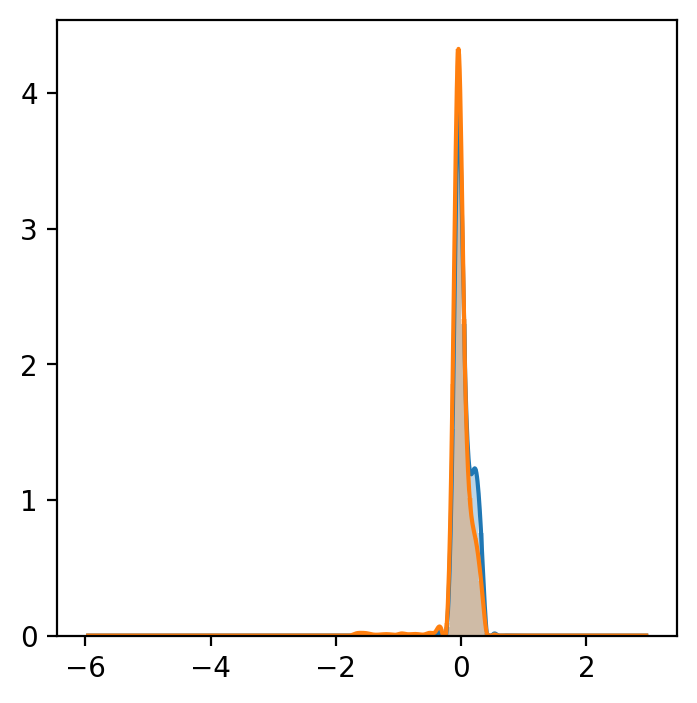

0.016704102653933635


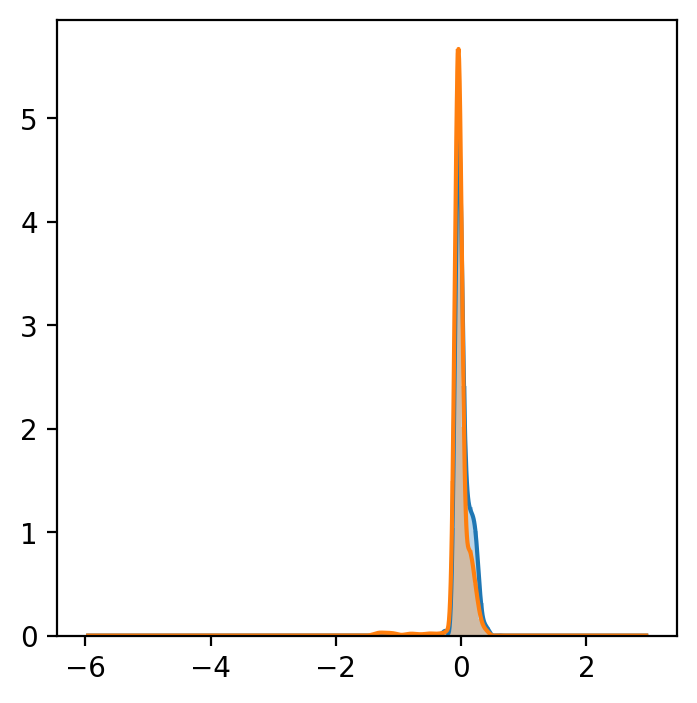

0.018055392139369908


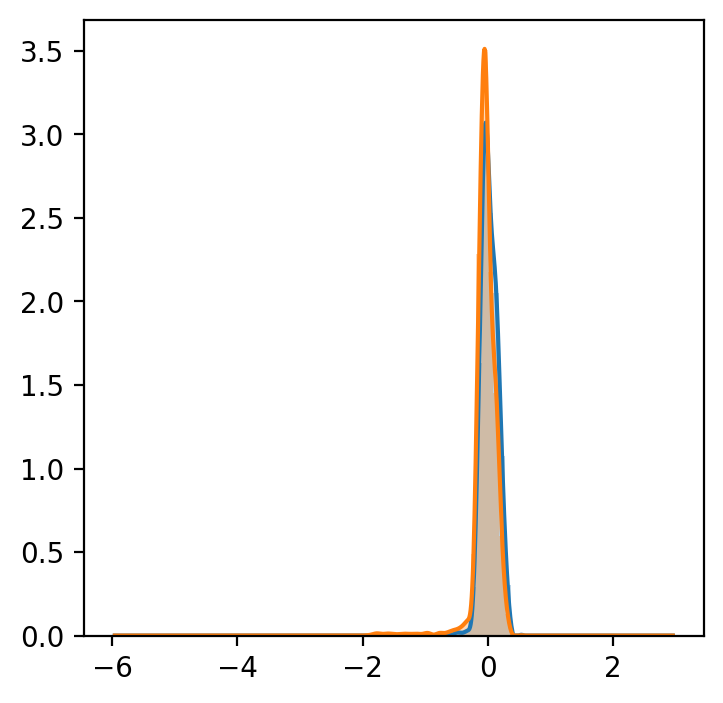

0.01590418313106575


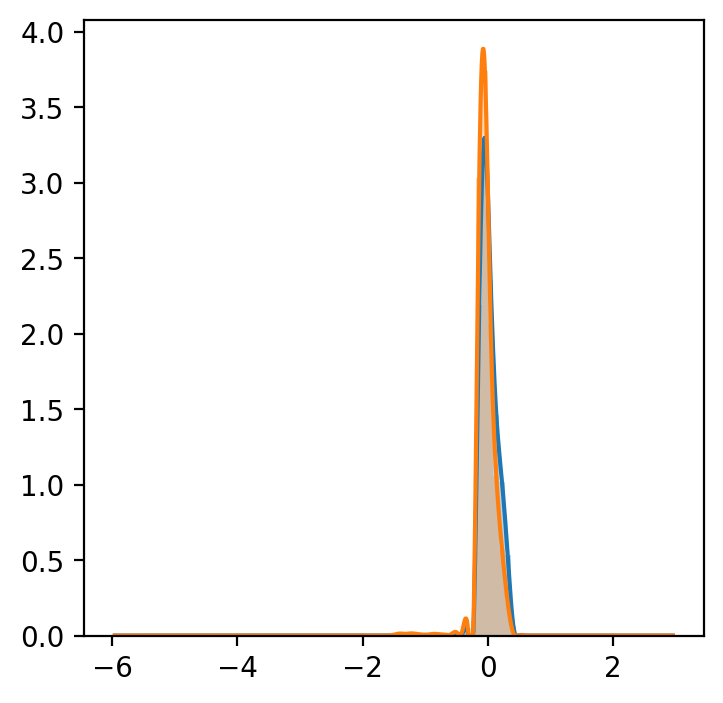

0.013819925392498957


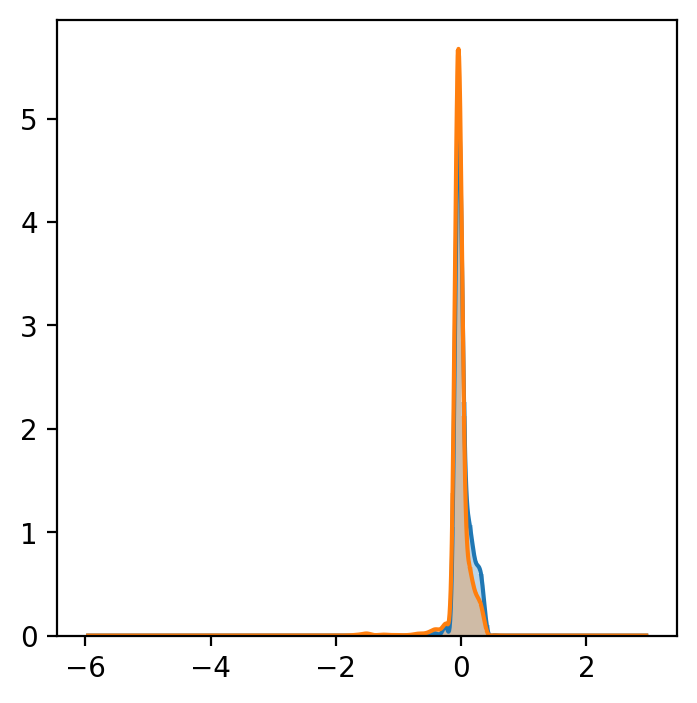

0.010394981195293182


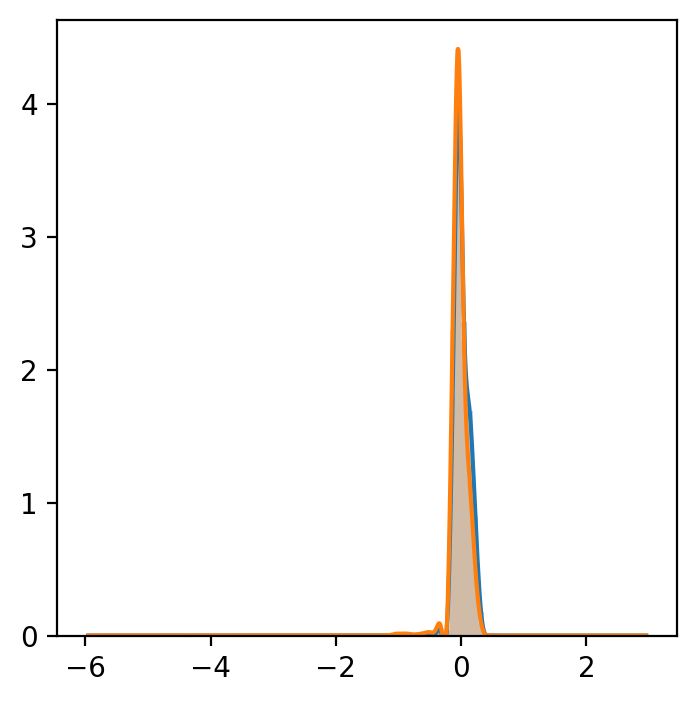

0.013908486280766293


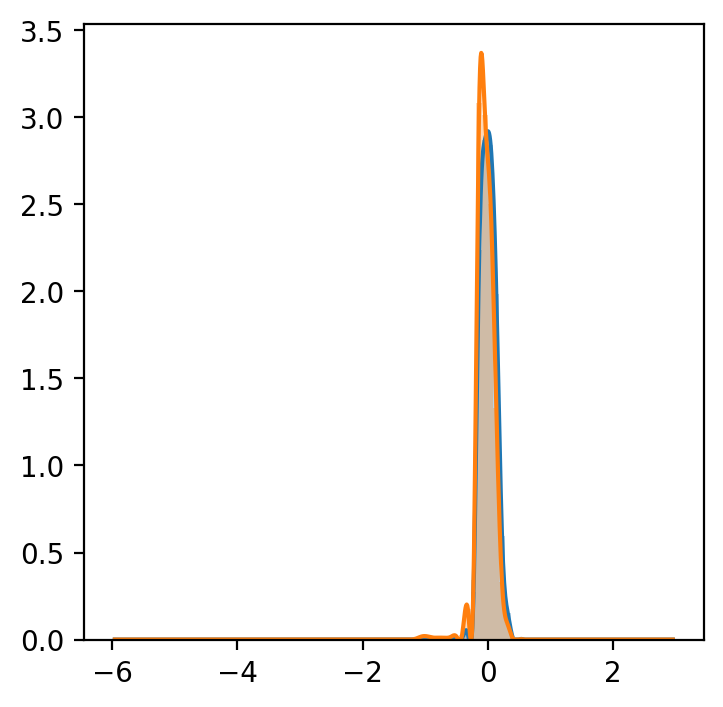

0.014756704295348822


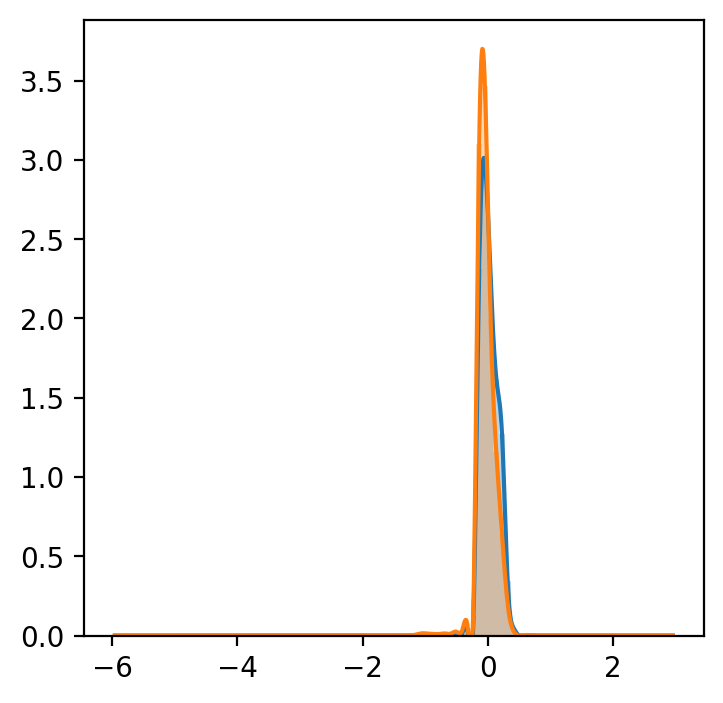

0.012616598612275858


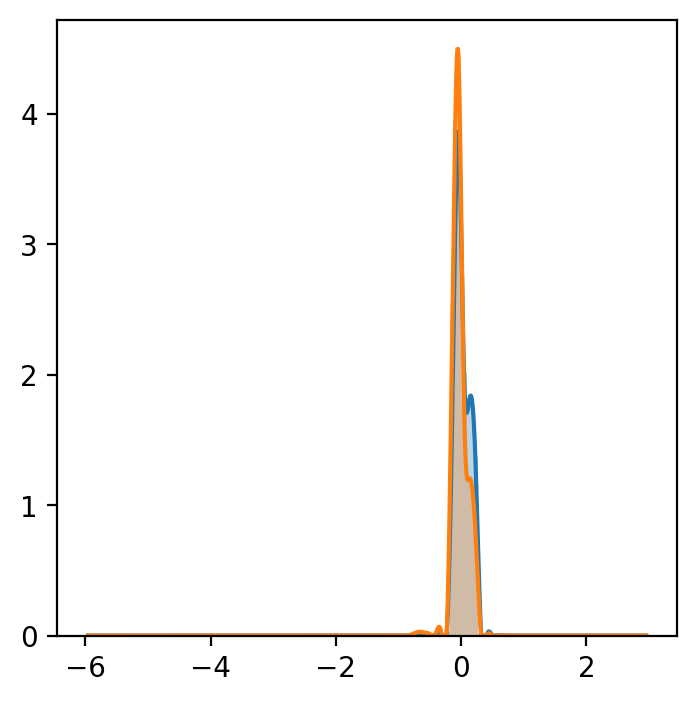

0.009734283014774853


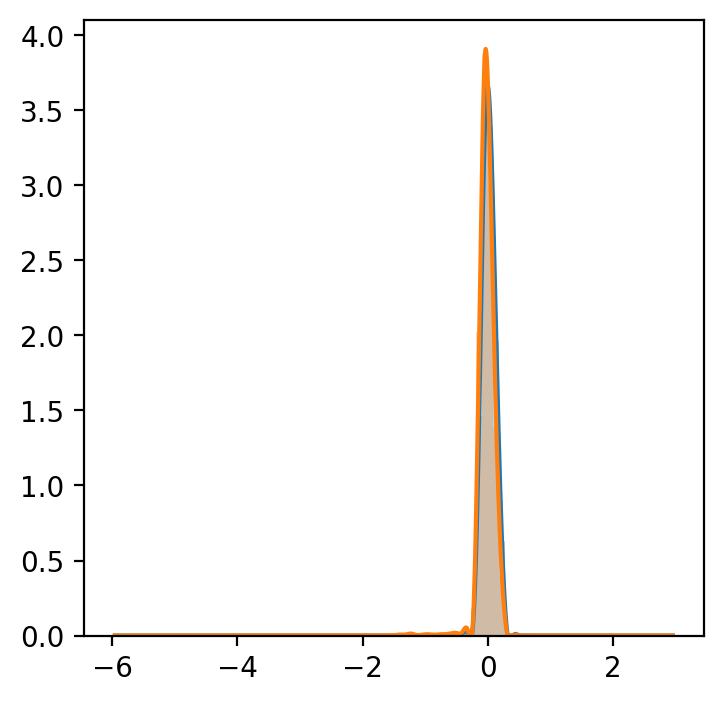

0.009007195780695589


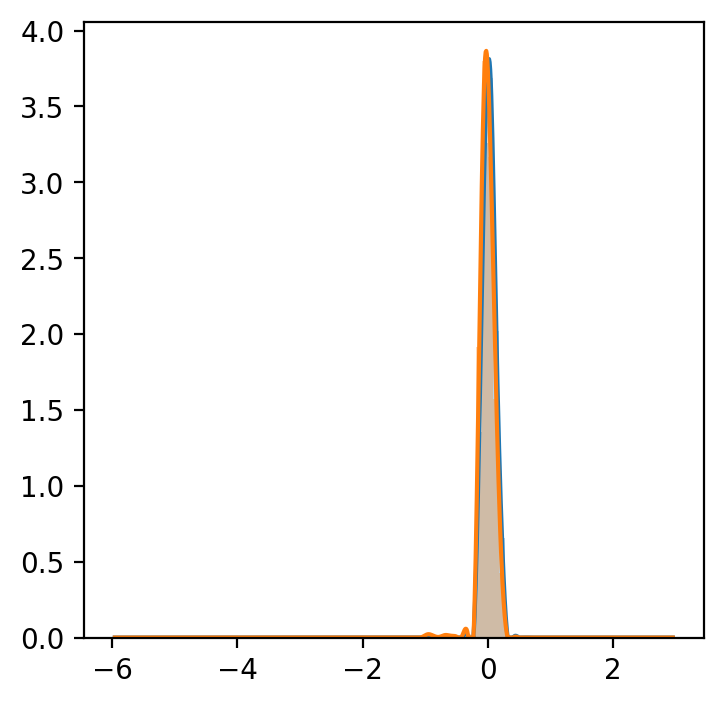

0.012811004479276307


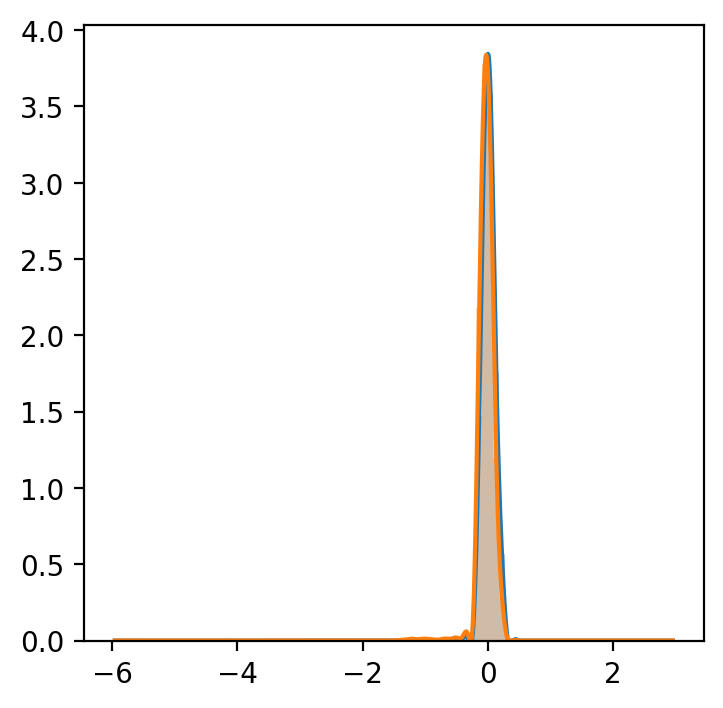

0.011652155068421774


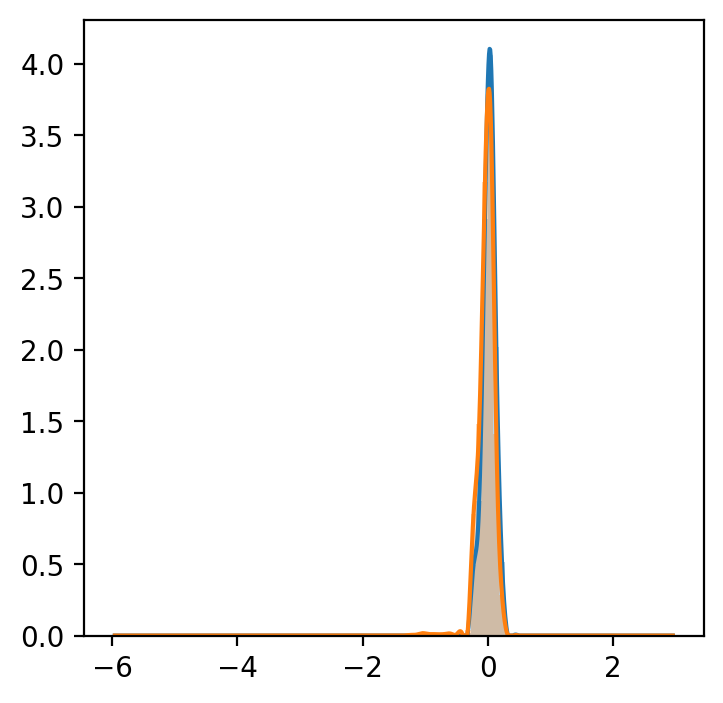

0.00979912213665087


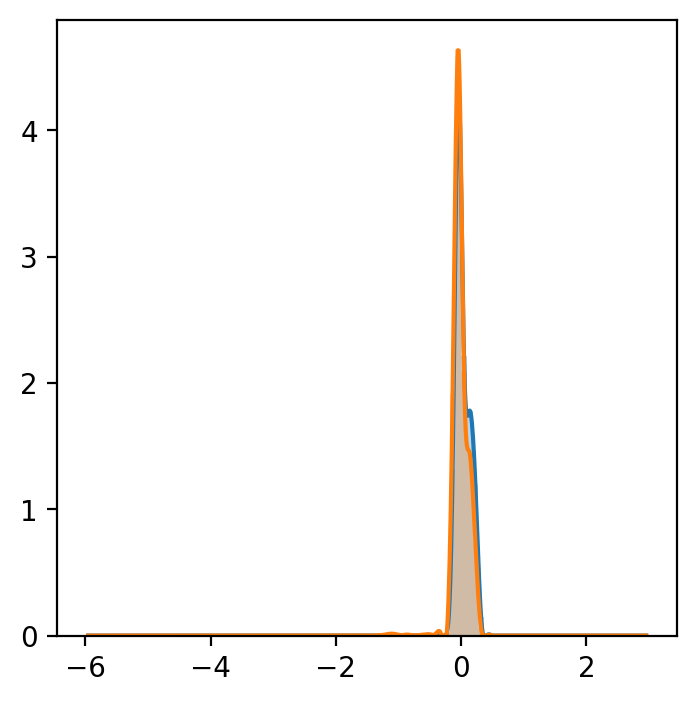

0.00792610181919083


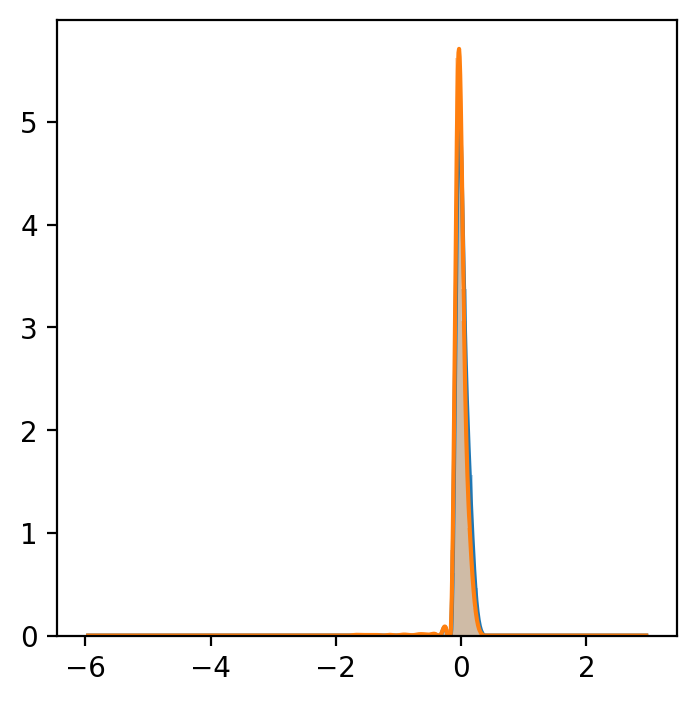

0.005182197508818131


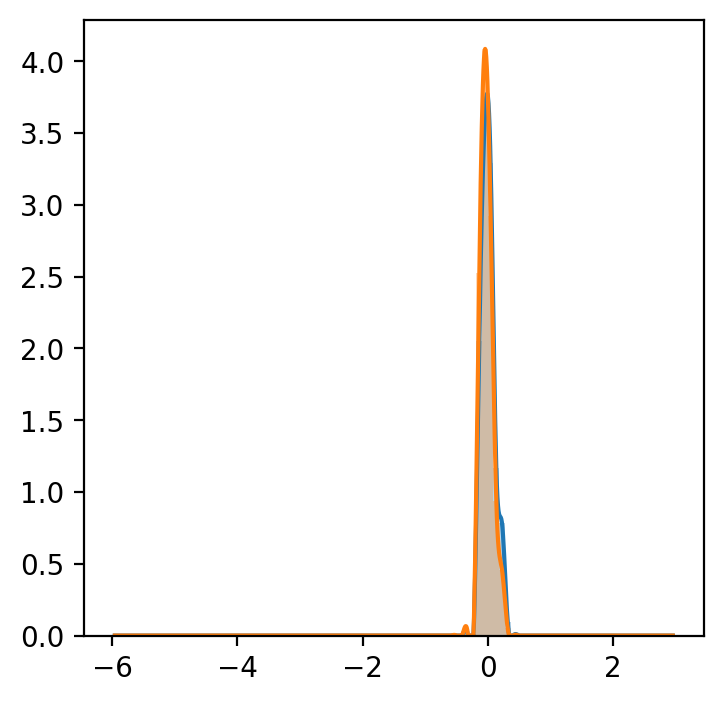

0.00871372475269682


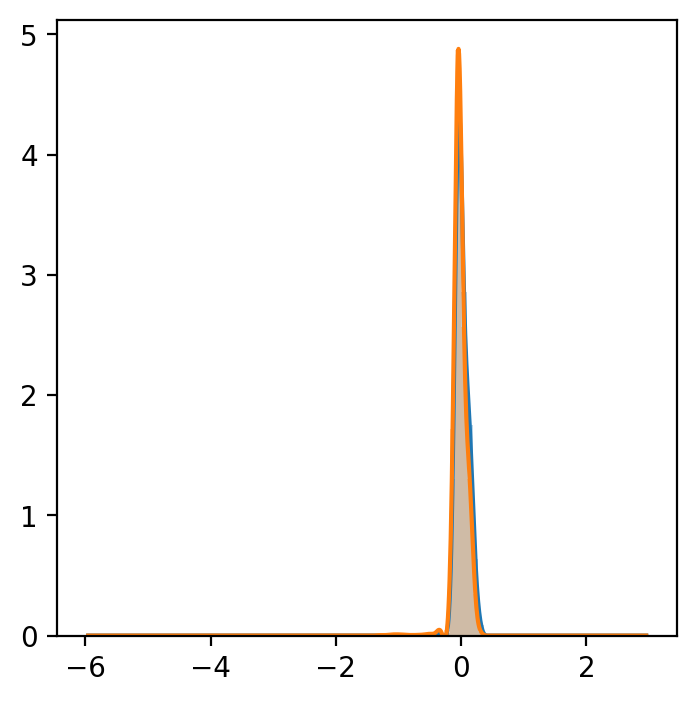

0.004452123731915159


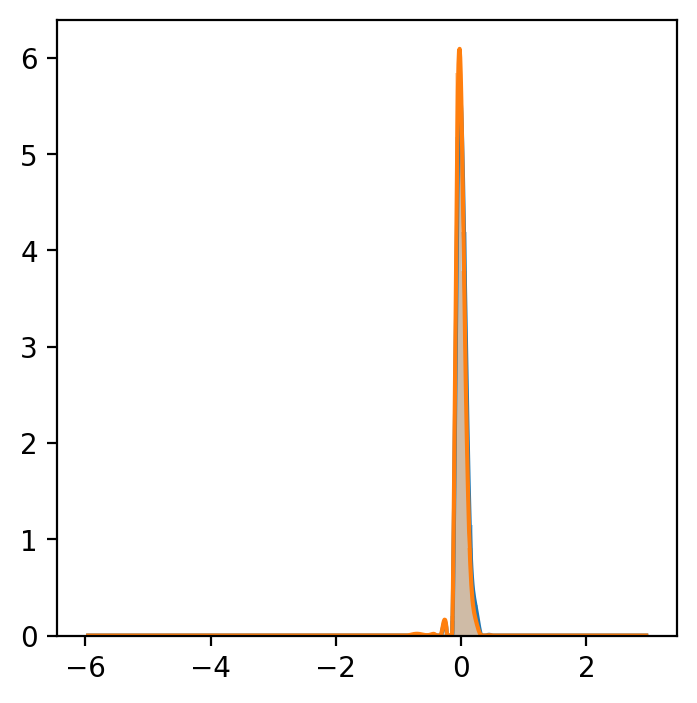

0.010668511723464743


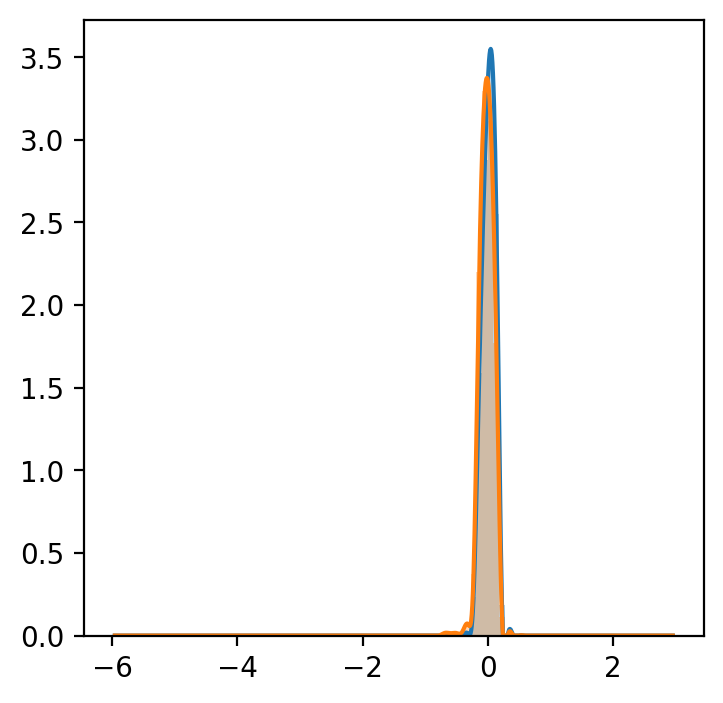

0.0061471708429584465


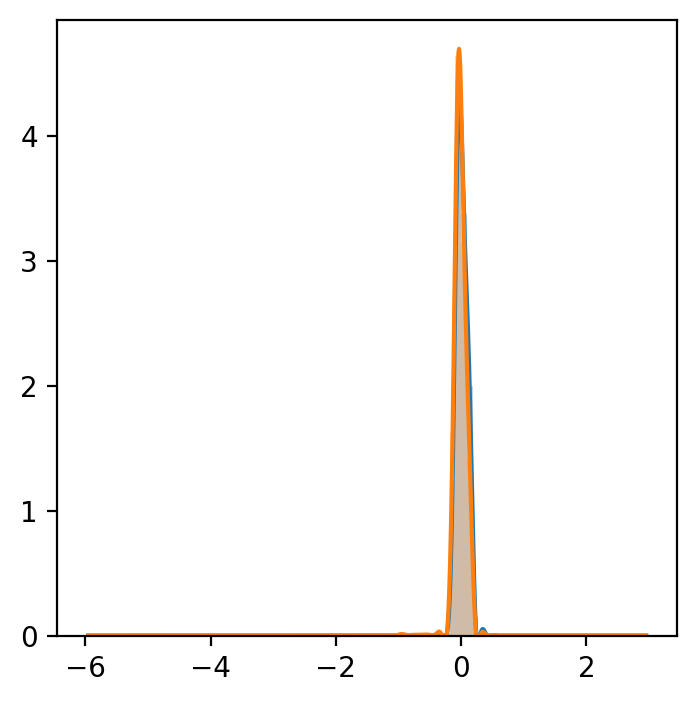

0.006283155648135956


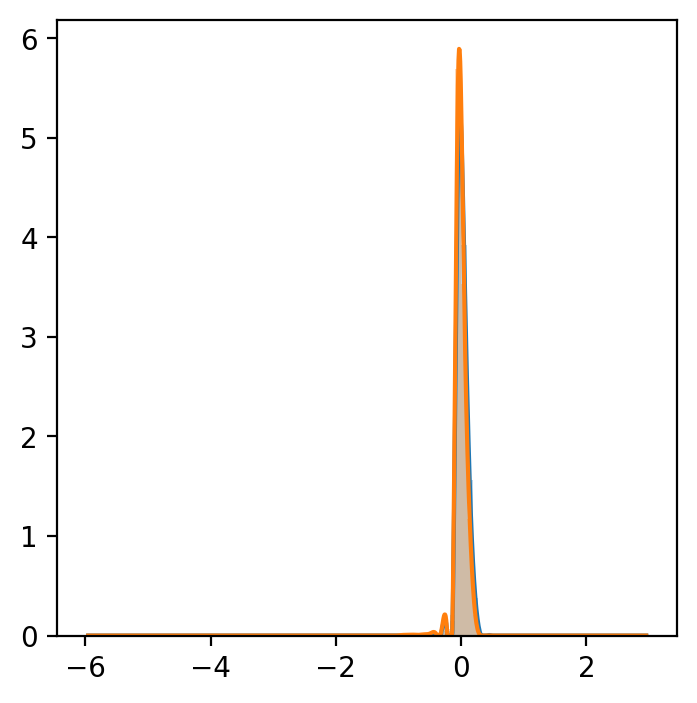

0.004431924307011577


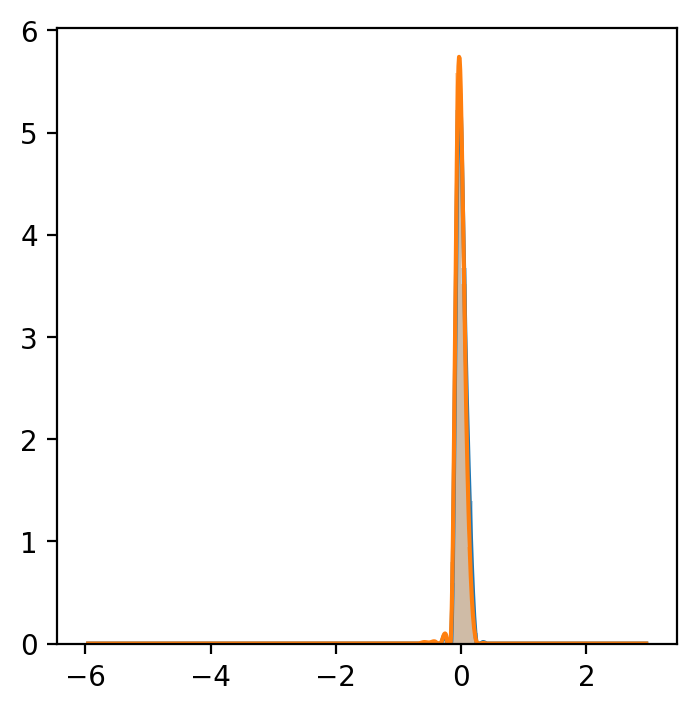

0.004938215742124591


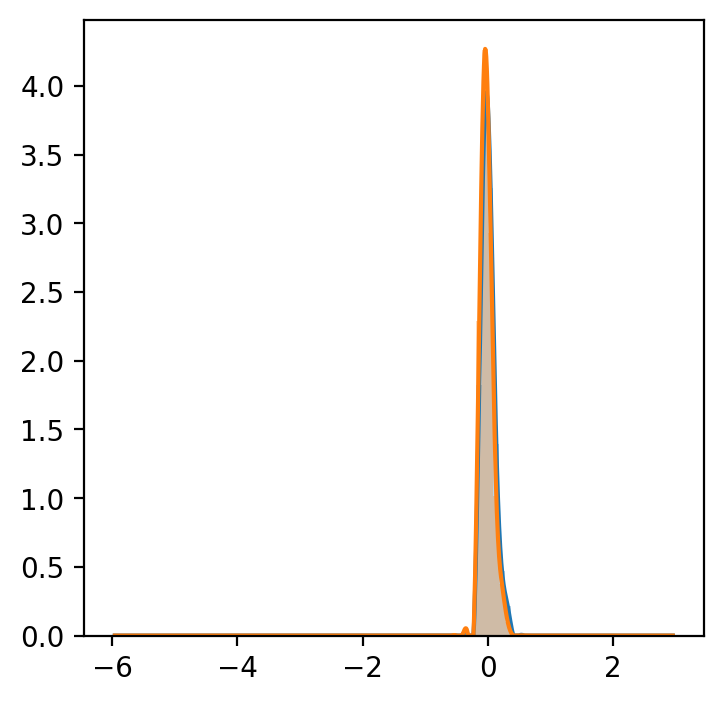

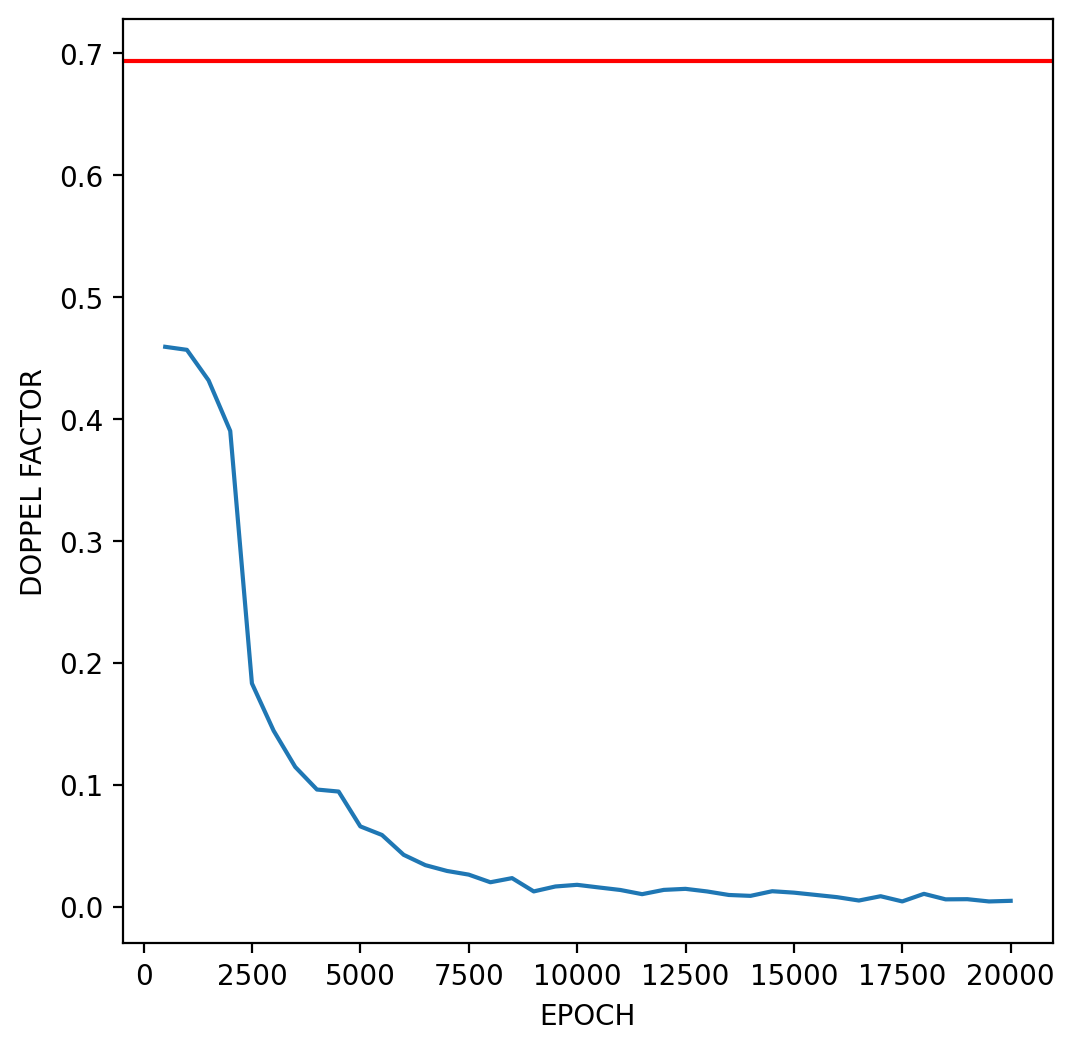

In [6]:
import pickle
import json
import sys
import swyft
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
epochs = [499 + 500 * i for i in range(40)]
JSDs = []
for epoch in epochs:
    model_probabilities_saved_real = np.load(f"result-real-{epoch}.npy")
    result1 = np.log10(model_probabilities_saved_real[:, 0])
    model_probabilities_saved_sims = np.load(f"result-sims-{epoch}.npy")
    result2 = np.log10(model_probabilities_saved_sims[:, 0])

    nbins = np.linspace(-6., 3.0, 100)

    fig = plt.figure(figsize=(4, 4))
    ax = plt.subplot(1, 1, 1)
    h, bins = np.histogram(
        result1, density=True, bins=nbins
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


    h, bins = np.histogram(
        result2, density=True, bins=nbins
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
    )
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

    x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))

    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)

    plt.plot(x_grid, fit_1(x_grid))
    plt.plot(x_grid, fit_2(x_grid))

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
    JSDs.append(JSD)
    print(JSD)
    plt.show()
fig = plt.figure(figsize=(6, 6))
plt.plot(epochs, JSDs)
plt.xlabel('EPOCH')
plt.ylabel("DOPPEL FACTOR")
plt.axhline(np.log(2), c='r')
plt.show()

1.3926754670793456e-05


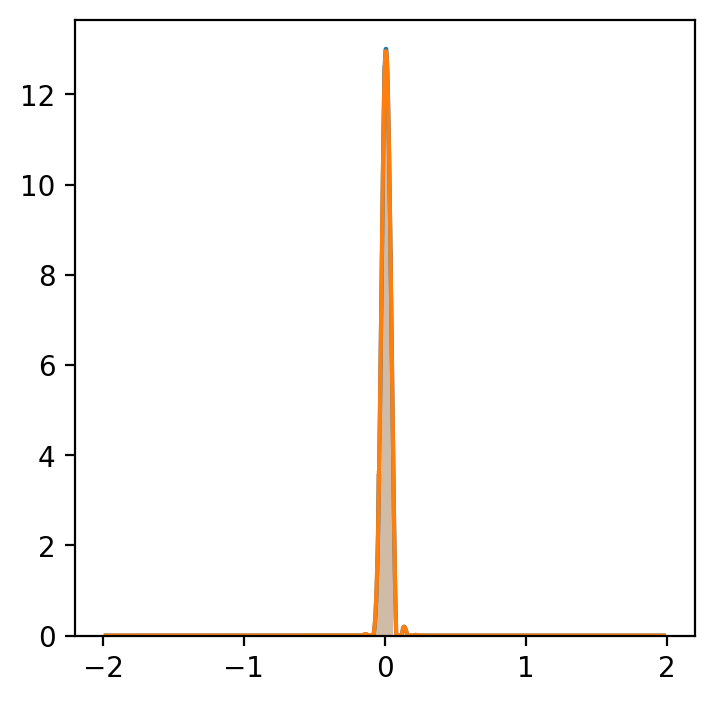

In [7]:
import pickle
import json
import sys
import swyft
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon

model_probabilities_saved_real = np.load(f"result-real-minimum.npy")
result1 = np.log10(model_probabilities_saved_real[:, 0])
model_probabilities_saved_sims = np.load(f"result-sims-minimum.npy")
result2 = np.log10(model_probabilities_saved_sims[:, 0])

nbins = np.linspace(-2., 2.0, 100)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
h, bins = np.histogram(
    result1, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min1, max1 = bin_centres[0], bin_centres[-1]
fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


h, bins = np.histogram(
    result2, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min2, max2 = bin_centres[0], bin_centres[-1]
fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)

def fit_1(x):
    return max(1e-10, fit1(x))

def fit_2(x):
    return max(1e-10, fit2(x))

fit_1 = np.vectorize(fit_1)
fit_2 = np.vectorize(fit_2)

plt.plot(x_grid, fit_1(x_grid))
plt.plot(x_grid, fit_2(x_grid))

JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
print(JSD)
plt.show()

0.00031914916556618074


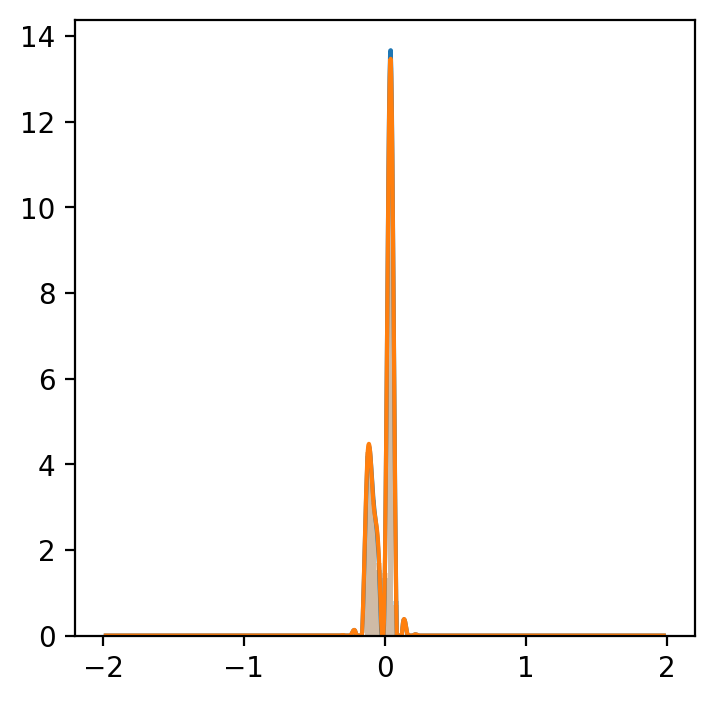

In [8]:
import pickle
import json
import sys
import swyft
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon

model_probabilities_saved_real = np.load(f"result-real-small.npy")
result1 = np.log10(model_probabilities_saved_real[:, 0])
model_probabilities_saved_sims = np.load(f"result-sims-small.npy")
result2 = np.log10(model_probabilities_saved_sims[:, 0])

nbins = np.linspace(-2., 2.0, 100)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
h, bins = np.histogram(
    result1, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min1, max1 = bin_centres[0], bin_centres[-1]
fit1 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")


h, bins = np.histogram(
    result2, density=True, bins=nbins
)
bin_centres = 0.5 * (bins[1:] + bins[0:-1])
plt.bar(
    bin_centres,
    h,
    width=bin_centres[1] - bin_centres[0],
    alpha=0.3,
)
min2, max2 = bin_centres[0], bin_centres[-1]
fit2 = interp1d(bin_centres, h, kind="cubic", fill_value="extrapolate")

x_grid = np.linspace(max(min1, min2), min(max1, max2), 1000)

def fit_1(x):
    return max(1e-10, fit1(x))

def fit_2(x):
    return max(1e-10, fit2(x))

fit_1 = np.vectorize(fit_1)
fit_2 = np.vectorize(fit_2)

plt.plot(x_grid, fit_1(x_grid))
plt.plot(x_grid, fit_2(x_grid))

JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid)) ** 2
print(JSD)
plt.show()

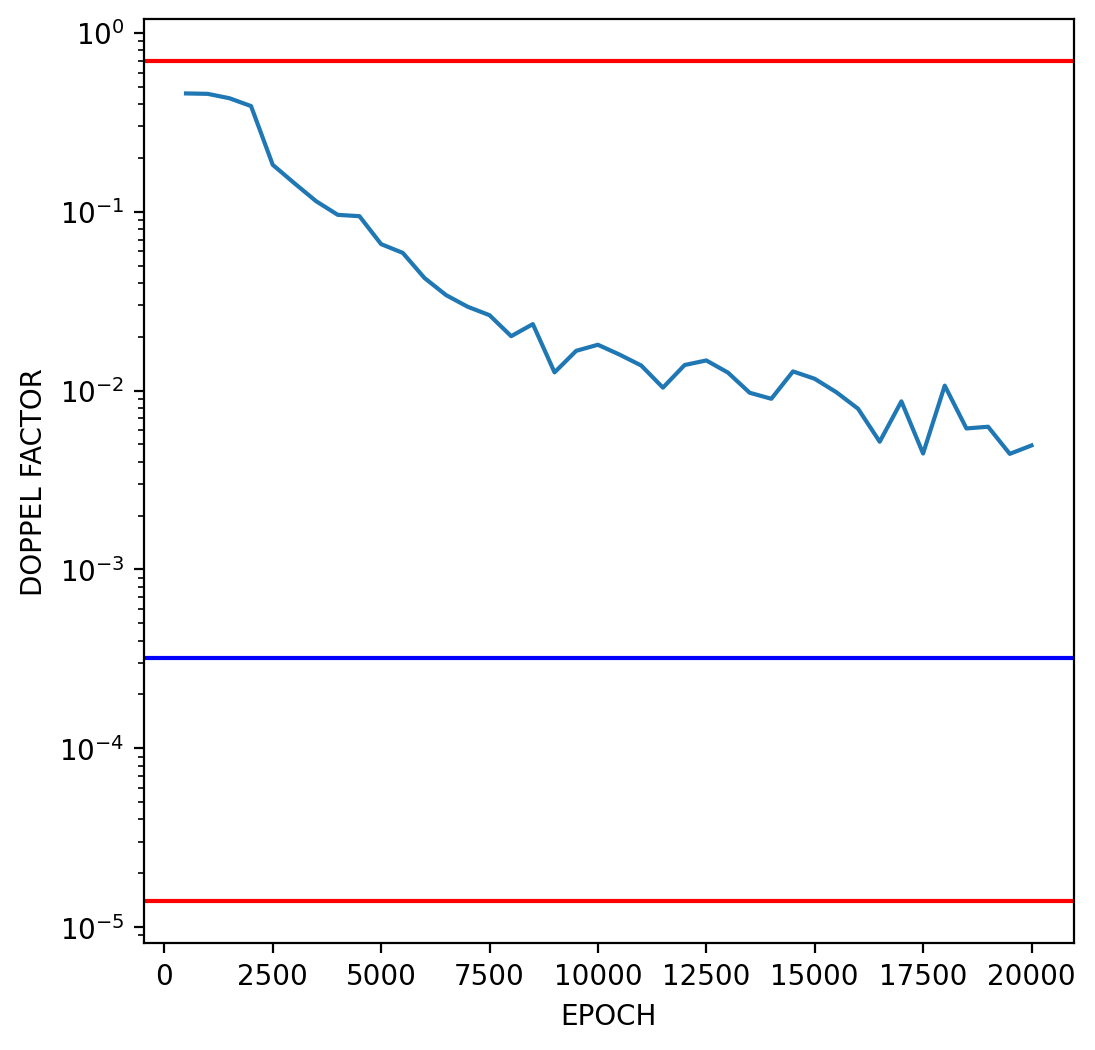

In [10]:
fig = plt.figure(figsize=(6, 6))
plt.plot(epochs, JSDs)
plt.xlabel('EPOCH')
plt.ylabel("DOPPEL FACTOR")
plt.axhline(np.log(2), c='r')
plt.axhline(0.00031914916556618074, c='b')
plt.axhline(1.3926754670793456e-05, c='r')
plt.yscale('log')
plt.show()